# Predicting Pitchfork Music Review Scores: Interpreting Text Linear Regression Models

In this mini-project, we'll build a simple linear regression nodel to predict Pitchfork review scores based solely on text. It's a difficult task to predict what an album's score will be, as music can be highly subjective. Features such as genre, release date, label, are not enough to capture this bias. However, the textual content of a review can give us the most clues. Building a decent NLP model based on these reviews can help us identify which chracteristics Pitchfork reviewers find the most important in order to differentiate between a good and a bad album. For example, if words such as 'ethereal' and 'heaven' are correlated with good scores, then we might guess that Pitchfork reviewers have a preference for albums that have that transcendental feel to them. Therefore, our priority will be to create a model that lends itself well to interpretability over everything else.

## Data Scraping

Most of the data was obtained from this [Kaggle dataset](https://www.kaggle.com/nolanbconaway/pitchfork-data), which contains reviews up until January 8, 2017. I went ahead and built a scraper with BeautifulSoup4 to collect the rest of the reviews. I was able to collect 2000+ additional reviews.

## Data Cleaning

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings('ignore')


In [3]:
reviews = pd.read_csv('../data/cleaned_reviews.csv')
reviews.head(3)

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,genre,year,content
0,3723.0,left for dead in malaysia,neil hamburger,http://pitchfork.com/reviews/albums/3723-left-...,6.5,0,jason josephes,contributor,1999-01-05,1,5,1,1999,NaN,NaN,Neil Hamburger's third comedy release is a des...
1,2413.0,"singles breaking up, vol. 1",don caballero,http://pitchfork.com/reviews/albums/2413-singl...,7.2,0,james p. wisdom,NaN,1999-01-12,1,12,1,1999,rock,1999.0,"Well, kids, I just went back and re-read my re..."
2,5376.0,out of tune,mojave 3,http://pitchfork.com/reviews/albums/5376-out-o...,6.3,0,jason josephes,contributor,1999-01-12,1,12,1,1999,rock,NaN,"Out of Tune is a Steve Martin album. Yes, I'l..."


First, we check for null values. Since we're only going to use the score and content columns, we check for only those two.

In [4]:
print('# of Missing Reviews:', reviews['content'].isna().sum())
print('# of Missing Scores:', reviews['score'].isna().sum())

# of Missing Reviews: 14
# of Missing Scores: 0


We simply get rid of those entries with no review content and drop all the other columns we won't use. I also want to get rid of reviews under a certain length. I'll get rid of reviews under 2000 words.

In [5]:
reviews = reviews[~reviews['content'].isnull()]
reviews['length'] = reviews['content'].apply(lambda x: len(str(x)) if x else None)
reviews = reviews[reviews['length'] >= 2000]
data = reviews[['title', 'artist', 'content', 'score']]
data.head(3)

,title,artist,content,score
1,"singles breaking up, vol. 1",don caballero,"Well, kids, I just went back and re-read my re...",7.2
2,out of tune,mojave 3,"Out of Tune is a Steve Martin album. Yes, I'l...",6.3
4,let us replay!,coldcut,The marketing guys of yer average modern megac...,8.9


Next, we'll do some basic NLP tasks to prepare our data. We'll get rid of punctuations and other non-alphanumeric characters since we won't be taking syntax into consideration. We'll also remove stopwords such as 'the' and 'an'. These are common English words that are just too repetitive to provide any insight into the particular text we're looking at. Finally, we will also stem each word in the corpus. Stemming is the process of reducing words to their root form. This way words such as 'killed' and 'killing' are reduced to the same word: 'kill'. Since we have a large corpus, I used stemming instead of lemmatization, in order to reduce the amount of tokens.

In [6]:
data['tokens'] = data['content']

In [7]:
def remove_punc(x):
     return re.sub(r'[.|,|)|(|\|/|?|!|#|\'|;]', r' ', x)

data['tokens'] = data['tokens'].apply(remove_punc)

In [8]:
from nltk.tokenize import word_tokenize

data['tokens'] = data['tokens'].apply(word_tokenize)

In [9]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stopset = set(stopwords.words('english'))
ps = PorterStemmer()

data['tokens'] = data['tokens'].apply(lambda x: [ps.stem(w).lower() for w in x if not w in stopset and len(w) > 3])

In [10]:
data.shape

(21091, 5)

## Score Distribution

Text(0, 0.5, 'Count')

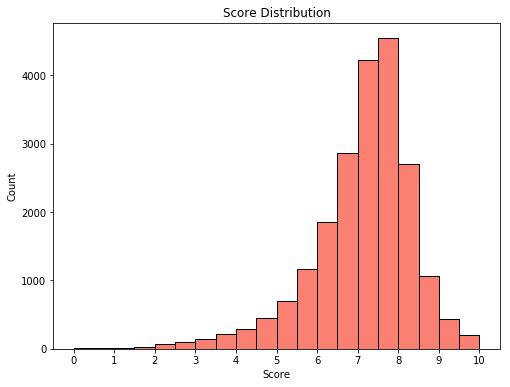

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(data['score'], bins=20, edgecolor='black', color='salmon')
ax.set_xticks(range(11))
ax.set_title('Score Distribution')
ax.set_xlabel('Score')
ax.set_ylabel('Count')

As we can see, we have a great data imbalance. Most scores tend to fall somewhere between the 6-8 range, while outer scores are underrepresented. This can definitely affect the accuracy of our model for predicting scores in those outer ranges. Though, this imbalance makes sense. Pitchfork will mostly review rising or well-established artists in certain music spheres. Artists won't make it to this point by releasing mediocre albums. Their albums, most often than not, will be at least decent.

# Machine Learning

Next, we'll need to transform our DataFrame to a TF-IDF bag of words model. Fortunately, sci-kit learn provides a really neat TF-IDF implementation. It allows us to extract the uni-grams and bi-grams of each review and apply some preprocessing such as stripping accent marks and ignoring non-alphanumeric characters. It also allows us to specificy the minimum document frequency each word will need in order to be included in the final feature space. In other words, tokens that appear in less than, say, 10 reviews will not be included. Dismissal of these infrequent words won't affect the accuracy of our model by much and will allow for faster model training.

In [12]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(data['tokens'].apply(' '.join), data['score'], test_size=0.2, random_state=42)

In [13]:
from sklearn.model_selection import train_test_split

tfidf_vec = TfidfVectorizer(analyzer='word', strip_accents='unicode',
                       lowercase =True, token_pattern=r'\w+', ngram_range=(1,2), min_df=10, max_df=0.5)

X_tfidf = tfidf_vec.fit_transform(X)
X_test_tfidf = tfidf_vec.transform(X_test)

In [14]:
X_tfidf

<16872x75015 sparse matrix of type '<class 'numpy.float64'>'
	with 5979330 stored elements in Compressed Sparse Row format>

Even after setting a minimum and maximum document frequency, we are left with a total of 75015 tokens. The problem with this is that we have more predictors than observations. In the case of regression, our least squares fit will perfectly fit the lower number of observations leading to a near perfeect train score and a bad test score (overfitting).

One solution would be to used Dimensionality Reduction techniques such as PCA to reduce the dimension of our sytem to, say, 500 features. Then, standard regression becomes an option and we're able to create a model that doesn't lose a lot of the information from the original system. However, it has the downside of making our model difficult to interpret. While we might get good results, our goal is to interpret our model in order to determine which features are the most relevant to a good review. So, we'll discard PCA as an option.

We need a model that can perform well when p > n AND is intepretable. Ridge and Lasso regression are perfect for this. These regularization methods prevent overfitting by imposing a less flexible fit on our data. We'll try both approaches.

## Lasso and Ridge Regression

We'll evaluate 20 possible alpha values through cross validation. Our scoring metric will be the mean absolute error. It allows us to directly interpret the results. A mean absolute error of say 0.9 indicates that our model will deviate from the true score by an average of 0.9 points.

In [15]:
cv = 5
alphas = np.logspace(-5,2,20)
scores_lasso = np.zeros((len(alphas), cv))
scores_ridge = np.zeros((len(alphas), cv))

for i in range(len(alphas)):
    print('Evaluating alpha value:', alphas[i])
    print('Evaluating Lasso...')
    lm = Lasso(alpha=alphas[i])
    scores_lasso[i,:] = -cross_val_score(lm, X_tfidf, y, scoring = 'neg_mean_absolute_error', cv=cv, verbose=2, n_jobs=5)
    print('Evaluation Ridge...')
    rm = Ridge(alpha=alphas[i])
    scores_ridge[i,:] = -cross_val_score(rm, X_tfidf, y, scoring = 'neg_mean_absolute_error', cv=cv, verbose=2, n_jobs=5)

Evaluating alpha value: 1e-05
Evaluating Lasso...


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  9.0min remaining: 13.5min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 26.1min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 26.1min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluation Ridge...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   44.6s remaining:  1.1min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   57.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   57.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluating alpha value: 2.3357214690901213e-05
Evaluating Lasso...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 15.9min remaining: 23.9min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 43.6min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 43.6min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluation Ridge...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   25.5s remaining:   38.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   41.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   41.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluating alpha value: 5.4555947811685143e-05
Evaluating Lasso...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  4.7min remaining:  7.1min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 18.0min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 18.0min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluation Ridge...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   11.5s remaining:   17.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   13.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluating alpha value: 0.00012742749857031334
Evaluating Lasso...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.6min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluation Ridge...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluating alpha value: 0.00029763514416313193
Evaluating Lasso...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   15.9s remaining:   23.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   17.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   17.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluation Ridge...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    6.3s remaining:    9.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluating alpha value: 0.0006951927961775605
Evaluating Lasso...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   10.9s remaining:   16.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   11.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluation Ridge...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluating alpha value: 0.001623776739188721
Evaluating Lasso...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    7.6s remaining:   11.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    7.7s finished


Evaluation Ridge...


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    6.1s remaining:    9.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluating alpha value: 0.00379269019073225
Evaluating Lasso...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluation Ridge...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluating alpha value: 0.008858667904100823
Evaluating Lasso...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluation Ridge...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.9s remaining:    8.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluating alpha value: 0.02069138081114788
Evaluating Lasso...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluation Ridge...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluating alpha value: 0.04832930238571752
Evaluating Lasso...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluation Ridge...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluating alpha value: 0.11288378916846883
Evaluating Lasso...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluation Ridge...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.1s remaining:    7.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluating alpha value: 0.26366508987303555
Evaluating Lasso...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s finished


Evaluation Ridge...


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.6s remaining:    6.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.8s finished


Evaluating alpha value: 0.6158482110660255
Evaluating Lasso...


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.7s remaining:    7.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluation Ridge...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.6s remaining:    5.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluating alpha value: 1.438449888287663
Evaluating Lasso...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluation Ridge...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.0s finished


Evaluating alpha value: 3.359818286283781
Evaluating Lasso...


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluation Ridge...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.7s finished


Evaluating alpha value: 7.847599703514606
Evaluating Lasso...


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluation Ridge...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s finished


Evaluating alpha value: 18.32980710832434
Evaluating Lasso...


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluation Ridge...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluating alpha value: 42.81332398719387
Evaluating Lasso...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s finished


Evaluation Ridge...


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluating alpha value: 100.0
Evaluating Lasso...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Evaluation Ridge...


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.8s finished


Best Alpha (Lasso): 5.4555947811685143e-05
MAE: 0.7202417915502403
Best Alpha (Ridge): 1.438449888287663
MAE: 0.7050955318299466


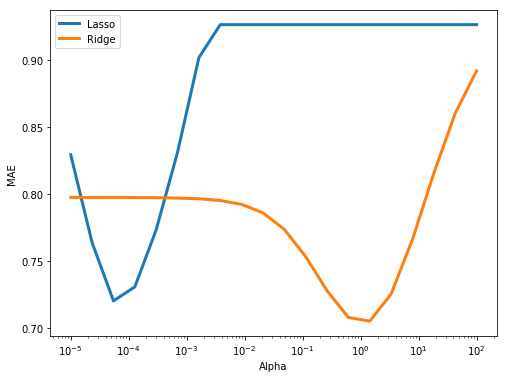

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

averages_lasso = scores_lasso.mean(axis=1)
averages_ridge = scores_ridge.mean(axis=1)

ax.plot(alphas, averages_lasso, label='Lasso', lw=3)
ax.plot(alphas, averages_ridge, label='Ridge', lw=3)
ax.set_xscale('log')
ax.set_ylabel('MAE')
ax.set_xlabel('Alpha')
ax.legend()

print('Best Alpha (Lasso):', alphas[np.argmin(averages_lasso)])
print('MAE:', min(averages_lasso))
print('Best Alpha (Ridge):', alphas[np.argmin(averages_ridge)])
print('MAE:', min(averages_ridge))

We get two different optimal alpha values for Lasso and Ridge, but first we'll see how a standard linear regression model does on our dataset as a baseline.

In [17]:
def print_evaluation(y, y_pred):
    print('R squared: {}'.format(r2_score(y, y_pred)))
    print('MSE: {}'.format(mean_squared_error(y, y_pred)))
    print('MAE: {}'.format(mean_absolute_error(y, y_pred)))

In [18]:
lr = LinearRegression()
lr.fit(X_tfidf, y)
print_evaluation(y, lr.predict(X_tfidf))

R squared: 0.9999999999994206
MSE: 9.199754594245474e-13
MAE: 6.844879787038535e-07


In [19]:
print_evaluation(y_test, lr.predict(X_test_tfidf))

R squared: 0.27927468232005903
MSE: 1.1337404111102578
MAE: 0.8174811205883479


As we can see, the training MAE is approximately zero, while the test MAE is 0.83. It's definitely overfitting. Let's see how well Lasso and Ridge do for our dataset using the optimal alphas we calculated.

In [20]:
alpha_lasso=alphas[np.argmin(averages_lasso)]
lm_min = Lasso(alpha=alpha_lasso)
lm_min.fit(X_tfidf, y)
print_evaluation(y_test, lm_min.predict(X_test_tfidf))

R squared: 0.42937186354169476
MSE: 0.8976293216698316
MAE: 0.6964224249679034


In [21]:
alpha_ridge = alphas[np.argmin(averages_ridge)]
rm_min = Ridge(alpha=alpha_ridge)
rm_min.fit(X_tfidf, y)
print_evaluation(y_test, rm_min.predict(X_test_tfidf))

R squared: 0.43738135561649727
MSE: 0.8850299518198834
MAE: 0.6885533895770881


In the end, Ridge seems to perform slightly better on our data. Ridge is expected to perform better when the target value depends on many predictors of roughly equal coefficients. Lasso is more likely to penalize several of these predictors, leading to an increase in test error. Therefore, we'll use the Ridge Regression model for interpretation.

We plot the predicted vs actual review scores for all the models using the test set. The linear regression model presents the most variance, followed by the Lasso and then the Ridge. All models do badly at predicting low scores (0-4 range) and very high scores (9-10 range), but Lasso is at least able to predict review scores less than 4. We anticipated this inaccuracy in those ranges since our data was highly imbalanced in favor of reviews in the 6-8 range. The Ridge model scored a Mean Absolute Error of 0.701. This means that on average the predicted score will be off by 0.701 points. Yet, we can expect it to do better on the 6-8 range. 

(0, 10)

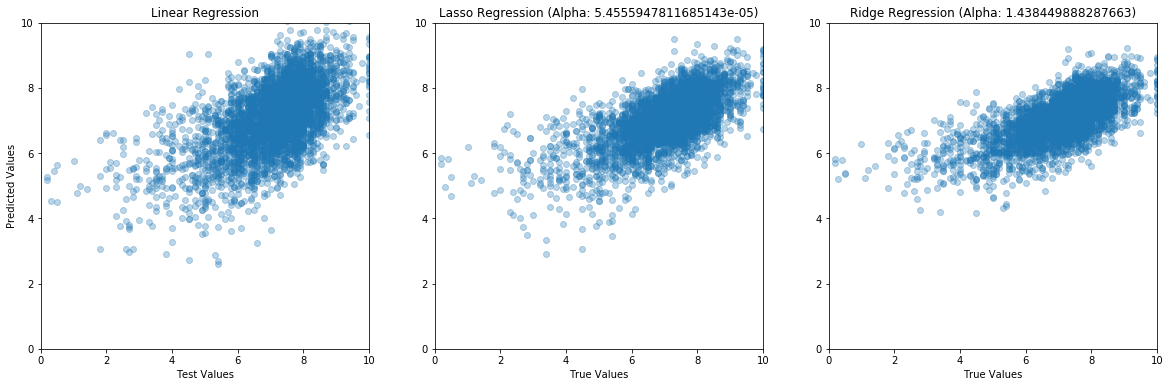

In [22]:
fig = plt.figure(figsize=(20,6))

ax=fig.add_subplot(131)
ax.scatter(y_test, lr.predict(X_test_tfidf), alpha=0.3)
ax.set_title('Linear Regression')
ax.set_xlabel('Test Values')
ax.set_ylabel('Predicted Values')
ax.set_xlim(0,10)
ax.set_ylim(0,10)

ax=fig.add_subplot(132)
ax.scatter(y_test, lm_min.predict(X_test_tfidf), alpha=0.3)
ax.set_title('Lasso Regression (Alpha: {})'.format(alpha_lasso))
ax.set_xlabel('True Values')
ax.set_xlim(0,10)
ax.set_ylim(0,10)

ax=fig.add_subplot(133)
ax.scatter(y_test, rm_min.predict(X_test_tfidf), alpha=0.3)
ax.set_title('Ridge Regression (Alpha: {})'.format(alpha_ridge))
ax.set_xlabel('True Values')
ax.set_xlim(0,10)
ax.set_ylim(0,10)

Fortunately, we're not that interested in acheiving the perfect score. We're more interested in the coefficients associated with each word, since our goal is to see which words lead to higher/lower review scores. We'll extract the top and bottom 30 coefficients to see which words have the most effect in our predicted score.

Text(0.5, 1.0, 'Ridge - Tokens with highest and lowest coefficients')

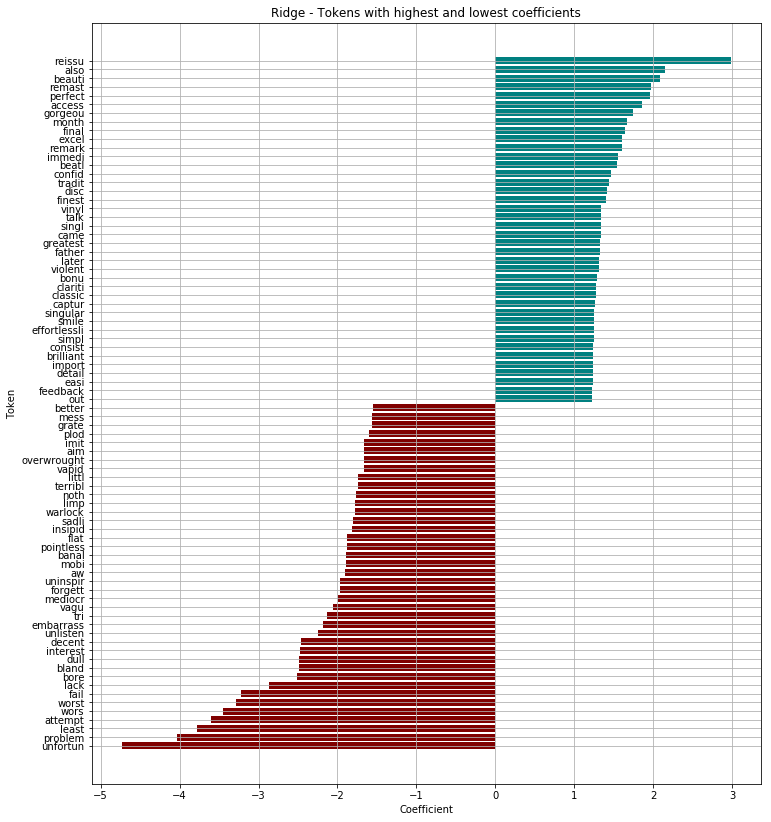

In [23]:
coefs = rm_min.coef_.copy()
feature_names = tfidf_vec.get_feature_names()

feature_coefs = list(zip(feature_names, coefs))
feature_coefs.sort(key=lambda x: x[1])

feature_names = [w for (w, _) in feature_coefs]
coefs = [c for (_, c) in feature_coefs]

fig, ax = plt.subplots(figsize=(12, 14))
ax.grid(zorder=0)
ax.barh(feature_names[:40], coefs[:40], color='maroon')
ax.barh(feature_names[-40:], coefs[-40:], color='teal')
ax.set_ylabel('Token')
ax.set_xlabel('Coefficient')
ax.set_title('Ridge - Tokens with highest and lowest coefficients')

First, thing to note is that inclusion of the bottom 40 words in a review will affect the score more than inclusion of the top 40 words. This highlights the score imbalance in Pitchfork reviews. Since there were far less bad reviews, the TF-IDF score of words in such reviews is increasingly higher, leading to higher absolute coefficient values.

We also see tokens that are directly related to an artist/band, such as 'veloso' and 'warlock'. This is due to our model overfitting those lower and upper ranges, for which we didn't have enough a lot of reviews. By looking at Pitchfork, we can see that Cateano Veloso's are all positive (all above 8.0) and The Warlocks' albums are all negative (all below 5.0). 

### Positive Coefficients

We have tokens such as 'reissu' and 'remast' at the top. Classic albums are usually reissued or remastered because of their critical acclaim. These albums will evidently have a higher average score than new albums. 'bonu'. short for bonus, is mostly used in the context of bonus tracks. These usually appear in reissued albums.

Then we have obvious tokens such as 'perfect', 'beauti', 'gorgeous', 'excel' and 'brilliant', all heightened versions of the word good. Great albums are guaranteed to have some combination of these words.

We need to inspect those words which are not synonyms for good. Not only that, we also need to analyze the context in which these words are used. We see tokens such as 'immedi', short for immediate, but it can have many meanings depending on how it's used. We'll create a function that prints the words surrounding each token, in order to infer their meaning. We'll explore some of the most descriptive words.

In [24]:
data['stemmed_content'] = data['content'].apply(lambda x: [ps.stem(w).lower() for w in x.split(' ')])

In [25]:
def find_context(token, score_range, n):
    results = data[(data['score'] >= score_range[0]) & (data['score'] <= score_range[1])].sample(frac=1,)
    results = results[results['stemmed_content'].apply(lambda x: token in x)]
    results['context'] = results\
                        .apply(lambda row: row['content']\
                        .split(' ')[row['stemmed_content'].index(token)-10: row['stemmed_content'].index(token)+10], axis=1)
    print('Token: {}\n'.format(token))
    for i in range(n):
        row = results.iloc[i]
        print('{} - {} ({}):\n "{}"\n'.format(row['artist'], row['title'], row['score'], ' '.join(row['context'])))

#### confid

In [168]:
find_context('confid', (8,10), 5)

Token: confid

built to spill - ancient melodies of the future (8.6):
 "suggesting that the trio have
    prematurely and confidently declared a new landmark by which all future
 "

the drones - gala mill (8.4):
 "their approach to painting these tableaus-- the
    confidence in allowing details and power to accrue sans some"

cex - maryland mansions (8.2):
 "of stifling banality is music.  But because he's not confident in his talents, it's a confession that
  "

ema - past life martyred saints (8.5):
 "just fell out of the world.It's a sign of her confidence and ambition that she can open the record with"

menomena - mines (8.2):
 "inadequacy, and age, sounding all the more unsettled amid the confident music.In fact, I've never spent so much time poring"



Pitchfork praises artists that confidently take risks or embark in new musical territory. It's not uncommon for artists to evolve their sound, but they have to show competency, conviction and assertiveness in their execution. Failure of correct execution can be the difference between a mediocre and a great review.

#### immedi

In [182]:
find_context('immedi', (8,10), 5)

Token: immedi

wire - read & burn 01 ep (8.0):
 " "Germ Ship" shows up about ten minutes in and immediately shifts the feel of the record, however briefly.
 "

grandaddy - the sophtware slump (8.5):
 "songs
    that are far hookier and more immediately accessible than Radiohead's.  The album's
   "

the glands - i can see my house from here (8.5):
 "They opted for tunes that felt close to done. What’s immediately striking is the lack of post-production clamor that characterizes"

petite noir - the king of anxiety ep (8.2):
 "arrive at something so slick and assured.The vocals are the immediate standout, as they were when Petite Noir first surfaced"

the replacements - for sale: live at maxwell’s 1986 (8.7):
 "Replacements hinges on the fact that their messiest moments could immediately be followed by triumphant, transcendent displays of rock’n’roll valor."



'immedi' tells us that many great albums immediately signal a striking characteristic. Pitchfork writers usually have less than a week to let an album sink in and make a score decision. Albums that efficiently display their strengths will have an easier time swaying a reviewer in the positive direction. 

#### access

In [184]:
find_context('access', (8,10), 5)

Token: access

jamie lidell - multiply (8.5):
 "for being difficult and forbidding, Multiply is among the most accessible records Warp has ever released. Backed by instrumentation from"

peter brtzmann, william parker, hamid drake - never too late but always too early (8.5):
 "seconds. The 45-minute piece is probably one of the most accessible avant-garde jazz moments     of the"

various artists - mutazione: italian electronic & new wave underground 1980 - 1988 (8.2):
 "Carmody, whose affably bleeping “Vulcani” is one of the most accessibly pop tracks on the compilation, says that the group"

giddy motors - do easy (8.0):
 "combination, don't be fooled, as Do Easy is even more accessible than the band's debut; it's still bleak and ugly,"

dlek - absence (8.3):
 "to beat-making and Dälek's modest flow make this album more accessible than its presecessor, 2002's From Filthy Tongue of Gods"



If we look at the context in which 'accessible' is used for some of the reviews, it is often in comparison to an unaccessible body of work. 'most accessible avant-garde jazz moments' and 'more accessible than the band's debut; it's still bleak and ugly' are examples of this. Taking risk goes both ways. An artist that usually outputs avant-garde albums can stand out by experimenting going 'non-experimental'.

### Negative Coefficients

For the negative coefficients, we see tokens such as 'unfortun', 'tri', 'attempt', 'fail', and 'sadli'. These imply that an album attempted something, but was ultimately disappointing in its execution. I think this is an effective way to review albums. A reviewer asks himself 'What is this album trying to acheive?', and then rates it depending on how well it succeeded or how badly it failed.

Expected tokens that show up are 'bland', 'dull', and 'pointless'. Let's explore the context of some of the more interesting negative words.

#### plod

In [26]:
find_context('plod', (0,5), 5)

Token: plod

massive attack - splitting the atom (4.4):
 "pedestrian, and the song doesn't move toward anything; it just plods quietly along for five minutes. "Pray for Rain" recruits"

asteroid no. 4 - honeyspot (3.0):
 "   George Jones rip-off, complete with a weary, plodding drumbeat and mournful steel guitar.  Frontman Scott
 "

robert pollard - the crawling distance (2.8):
 "But apart from piling a few extra effects onto the plodding "Harlequin", he's giving each and every song its most"

css - planta (5.0):
 "“I’ve never had a hangover til you,” over a slowly plodding and sunny reggaeton beat. Front-woman Lovefoxxx adopts a drawl"

emptymansions - snakes/vultures/sulfate (3.2):
 "practice, it’s nothing but craggy vocals, meaty riffs served medium-well, plodding rhythms, implicit Pixies worship and explicit Neil Young worship;"



To plod means to advance slowly. In the context of Pitchfork reviews, it addresses songs or instrumental pieces that drag out for too long. "plodding rhythms" are considered a lazy way of adding content to songs. 

#### imit

In [35]:
find_context('imit', (0,5), 5)

Token: imit

the cribs - the new fellas (3.0):
 "the naive mimcry of some of these songs. The Strokes imitations are frequent and blatant, though they bring a cheeky"

dntel - aimlessness (5.0):
 "to listen, you could hear the Postal Service and their imitators everywhere, and the more your heard their sound, the"

the mooney suzuki - alive & amplified (5.0):
 "Dolls, and "Sometimes Somethin'"
    is an effective imitation of overwrought Stones balladry, though it sounds out of"

6ix9ine - dummy boy (3.4):
 "Curry and Lil Pump—to lace him up with a cheap, imitation reggaeton track. On the Lil Baby-featuring “TIC TOC,” Tekashi"

vietnam - the concrete's always grayer on the other side of the street ep (5.0):
 "describe this music without comparison, but Vietnam is so self-consciously imitative they practically
    beg for a bullet"



While it's essential for artists to take influence from other artists, blatant imitation comes off as distasteful and disrespectful. A great example is the band Greta van Fleet, a band that has received a lot of criticism because they sound exactly like Led Zeppelin. Their music is decent in a vacuum, but the imitation makes their content unlistenable for many.

#### limp

In [35]:
find_context('limp', (0,5), 5)

Token: limp

ulrich schnauss - a long way to fall (4.3):
 "bored with [that synthesized shoegaze sound]." Fall finds Schnauss ditching the limp vocals and siccing his impressive gear collection on slowly"

the lucksmiths - where were we? (4.7):
 "  every catchy number like that there are two limp ones, dragged down
    by awkward rhymes,"

homeshake - helium (3.5):
 "hangover, and its drums have the grain and snap of limp celery. The alleged impact of Young Thug, one of"

piano magic - life has not finished with me yet (4.5):
 "clinical depression and suicidal ideation if it wasn't played so limp and straight.Or maybe it's just the way he sings"

various artists - bbc radio 1: established 1967 (3.4):
 "the end, and yet never gets as interesting as even Limp Bizkit's nu-metal version of "Faith". But credit goes to"



This one was interesting, because it seems that the token 'limp' comes from two different contexts. First, Pitchfork refers to songs or segments as limp when they drag down an overall decent body of work. And second, Pitchfork seems to dislike Limp Bizkit, and any band that sounds like them. 

# Conclusion

By building a decent predictive model, we were able to get a basic idea of which qualities are correlated with good and bad album reviews. Personally, I was able to learn a lot about the NLP project workflow, which consists of cleaning and tokenizing the text, weighing each token through the TF-IDF, and using each token as a feature for a machine learning model. In the end, we chose the Ridge Regression model, because it gave us a good MAE and was also intepretable.

To finish it off, I created a worldcloud displaying the most positive and the most negative tokens as classified by our model.

(-0.5, 1599.5, 799.5, -0.5)

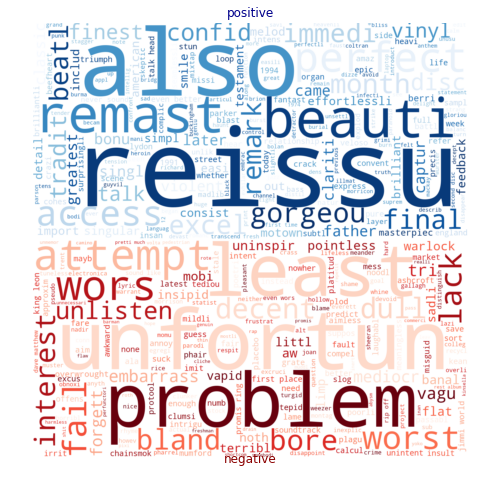

In [33]:
posdist = dict(zip(feature_names,coefs))
negdist = dict(zip(feature_names,[-1*i for i in coefs]))

poswordcloud = WordCloud(background_color='white', width=1600, height=800, colormap=plt.get_cmap('Blues'))\
                .generate_from_frequencies(posdist)
negwordcloud = WordCloud(background_color='white', width=1600, height=800, colormap=plt.get_cmap('Reds'))\
                .generate_from_frequencies(negdist)

fig = plt.figure(figsize=(12,8))
plt.subplots_adjust(wspace=0.1, hspace=0)


ax1 = fig.add_subplot(2,1,1)
ax1.imshow(poswordcloud, interpolation='bilinear')
ax1.set_title('positive', color='darkblue')
ax1.axis('off')

ax2 = fig.add_subplot(2,1,2)
ax2.imshow(negwordcloud, interpolation='bilinear')
ax2.set_title('negative', color='darkred', y=-0.05)
ax2.axis('off')